In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import zipfile, os
import random
import glob

from PIL import Image as mpig
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from warnings import filterwarnings
from sklearn.metrics import classification_report

%matplotlib inline


## Extract dataset

In [2]:
base_dir = '../Dataset/brain mri/'
train_dir = os.path.join(base_dir, 'Training/')
test_dir = os.path.join(base_dir, 'Testing/')
class_name = os.listdir('dataset/Training/')
class_name

['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
batch_size = 32
epoch = 25
image_size = 224

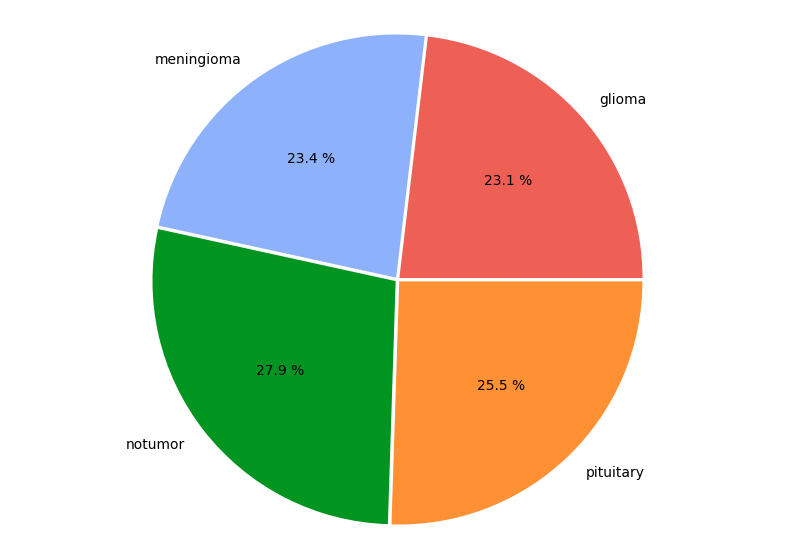

[1321, 1339, 1595, 1457]


In [4]:
plt.figure(figsize=(10,7))
numImages = [len(os.listdir(train_dir + "/" + label)) for label in class_name] 
colors = ["#EE6055","#8DB1FA","#009421","#FF9033"]
desfase = (0.01, 0.01, 0.01, 0.01)
plt.pie(numImages, labels=class_name, autopct="%0.1f %%", colors=colors, explode=desfase)
plt.axis('equal')
plt.show()
print(numImages)

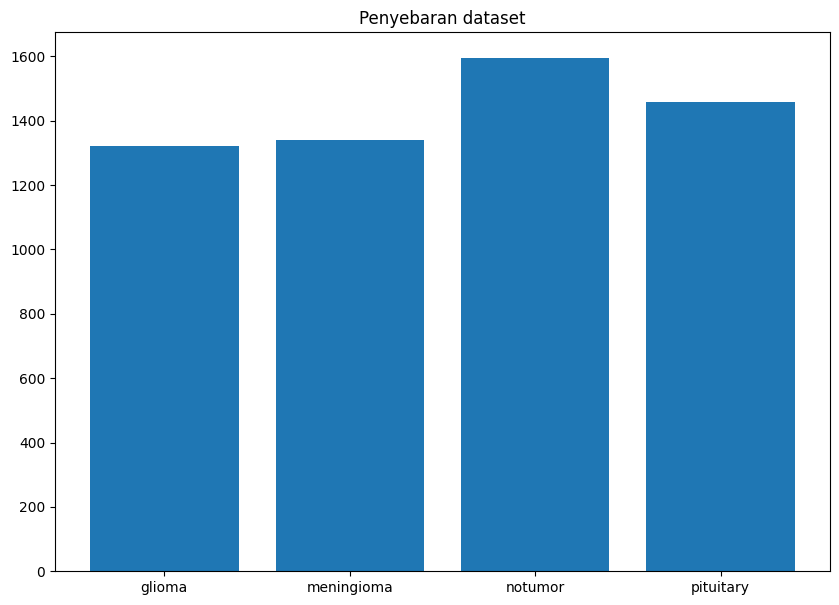

In [5]:
plt.figure(figsize=(10,7))
plt.bar(class_name, numImages)
plt.title('Penyebaran dataset')
plt.show()


## Menampilkan sample gambar berdasarkan class/jenis tumor

In [6]:
def plot_one_sample_of_each(base_path):
    cols = 4
    rows = int(np.ceil(len(class_name) / cols))
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(len(class_name)):
        cls = class_name[i]
        img_path = base_path + cls + '/'
        path_contents = glob.glob(img_path + '*.jpg')
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(plt.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

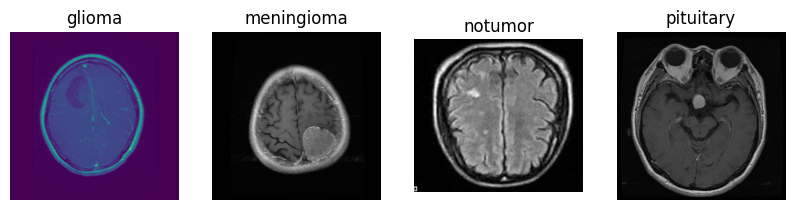

In [7]:
plot_one_sample_of_each(train_dir)

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    classes=class_name,
    subset='training',
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    classes=class_name,
    subset='validation',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size,image_size),
    shuffle=False,
    batch_size=batch_size
)

train_step_per_epoch = np.ceil(train_generator.samples//batch_size+1)
val_step_per_epoch = np.ceil(validation_generator.samples//batch_size+1)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size,image_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
    
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 512)       5

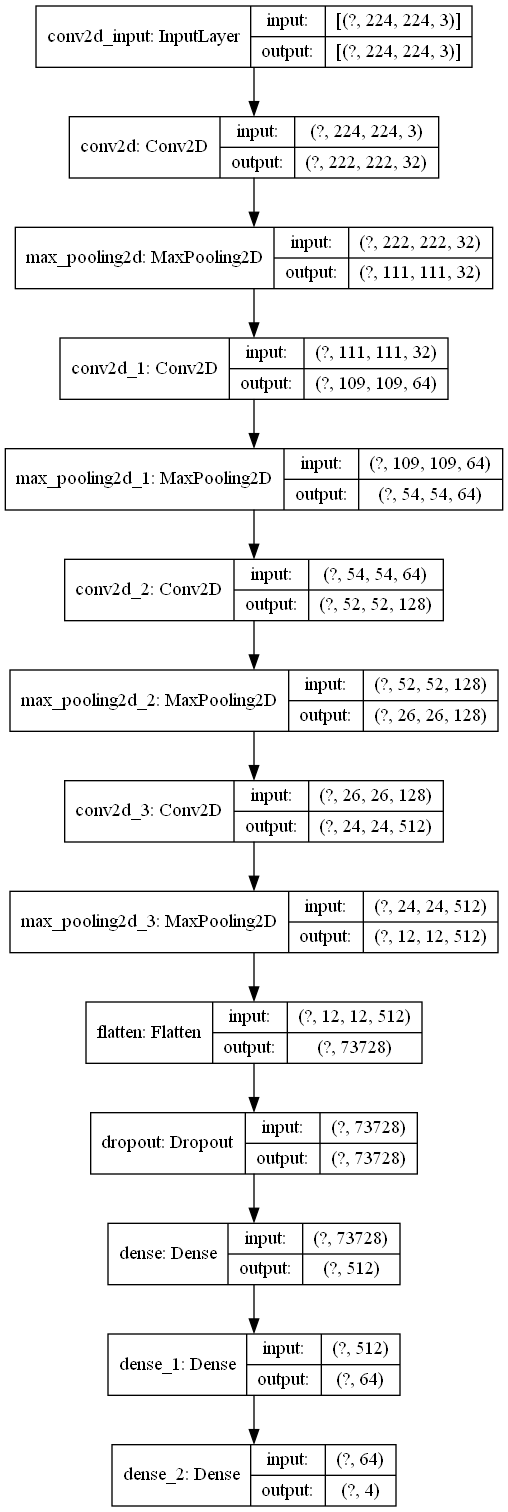

In [12]:
plot_model(model=model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.99):
            print("\nTraining model di hentikan karena sudah memenuhi target accuracy 99%")
            self.model.stop_training = True
callbacks = MyCallback()

checkpoint = ModelCheckpoint('cnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_delta=0.001, mode='auto', verbose=1)

In [14]:
model.compile(optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])


In [15]:
filterwarnings('ignore')

history = model.fit(
    train_generator,
    steps_per_epoch=train_step_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_step_per_epoch,
    batch_size=batch_size,
    verbose=1,
    callbacks=[callbacks, checkpoint, reduce_lr],
    )

Epoch 1/100
143/143 [==============================] - ETA: 0s - loss: 0.9236 - accuracy: 0.5848
Epoch 00001: val_accuracy improved from -inf to 0.60911, saving model to cnn_model.h5
143/143 [==============================] - 385s 3s/step - loss: 0.9236 - accuracy: 0.5848 - val_loss: 1.0425 - val_accuracy: 0.6091
Epoch 2/100
143/143 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.7375
Epoch 00002: val_accuracy improved from 0.60911 to 0.70114, saving model to cnn_model.h5
143/143 [==============================] - 264s 2s/step - loss: 0.6397 - accuracy: 0.7375 - val_loss: 0.8467 - val_accuracy: 0.7011
Epoch 3/100
143/143 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7681
Epoch 00003: val_accuracy improved from 0.70114 to 0.70377, saving model to cnn_model.h5
143/143 [==============================] - 309s 2s/step - loss: 0.5518 - accuracy: 0.7681 - val_loss: 0.7870 - val_accuracy: 0.7038
Epoch 4/100
143/143 [============================

In [16]:
model.save('cnn_model.h5')

In [18]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
    return

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show() 
    return

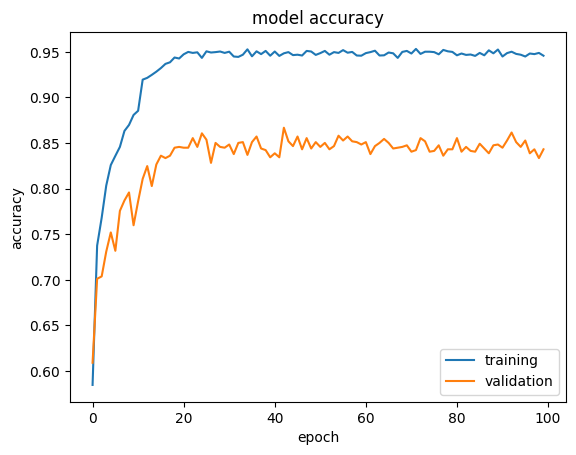

In [20]:
plot_accuracy(history)

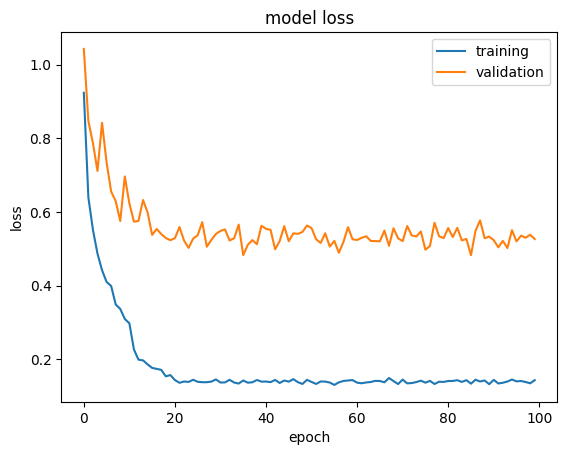

In [21]:
plot_loss(history)

In [22]:
models = load_model('cnn_model.h5', compile=True)
pred = models.evaluate(test_generator)


print(f'accuracy: {round(pred[1], 2) * 100}%')


41/41 [==============================] - 18s 428ms/step - loss: 0.3704 - accuracy: 0.8810
accuracy: 88.0%


In [23]:
pred = models.predict(test_generator)
y_pred = np.argmax(pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=class_name))

              precision    recall  f1-score   support

      glioma       0.96      0.80      0.87       300
  meningioma       0.84      0.70      0.76       306
     notumor       0.84      1.00      0.91       405
   pituitary       0.92      0.99      0.95       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



In [4]:
models = load_model('weight/cnn_model.h5', compile=True)
def predict_img(path, model):
    img_path = path
    img_source = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_size,image_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img_source).astype('float32')/255
    img_array = np.expand_dims(img_array, axis=0)

    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    prob = np.max(predict)
    cls_idx = np.argmax(score, axis=-1)
    img_plot = plt.imshow(img_source)

    plt.figure(figsize=(4, 4))
    print(img_path)

    print(f'Berdasarkan hasil prediksi, gambar dideteksi sebagai {class_name[cls_idx]} dengan nilai probabilitas {prob:.2f} % .')


PituitaryAdenoma.jpeg
[[7.1353666e-06 6.4290613e-03 2.4547581e-01 7.4808794e-01]]
tf.Tensor([0.1852674  0.186461   0.23681252 0.39145908], shape=(4,), dtype=float32)
Berdasarkan hasil prediksi, gambar dideteksi sebagai pituitary dengan nilai probabilitas 0.75 % .


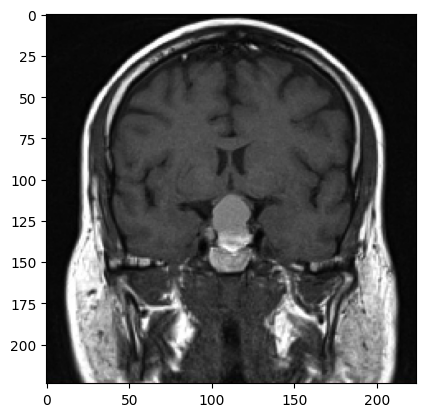

<Figure size 400x400 with 0 Axes>

In [5]:
predict_img('PituitaryAdenoma.jpeg', model=models)

In [6]:
model2 = tf.keras.models.Sequential([
    VGG16(weights='imagenet', include_top=False, input_tensor=tf.keras.layers.Input(shape=(image_size,image_size, 3))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model2.layers[0].trainable = False

In [7]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 27,593,348
Trainable params: 12,878,660
Non-trainable params: 14,714,688
___________________________________

In [8]:
model2.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint2 = ModelCheckpoint('vgg16_model.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [15]:
filterwarnings('ignore')

model2_history = model2.fit(
    train_generator,
    steps_per_epoch=train_step_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_step_per_epoch,
    batch_size=batch_size,
    verbose=1,
    callbacks=[callbacks, checkpoint2, reduce_lr]
)

Epoch 1/100
143/143 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.7666
Epoch 00001: val_accuracy improved from -inf to 0.70465, saving model to vgg16_model.h5
143/143 [==============================] - 367s 3s/step - loss: 0.7404 - accuracy: 0.7666 - val_loss: 0.8033 - val_accuracy: 0.7046
Epoch 2/100
143/143 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.8525
Epoch 00002: val_accuracy improved from 0.70465 to 0.78440, saving model to vgg16_model.h5
143/143 [==============================] - 342s 2s/step - loss: 0.4009 - accuracy: 0.8525 - val_loss: 0.5867 - val_accuracy: 0.7844
Epoch 3/100
143/143 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8742
Epoch 00003: val_accuracy improved from 0.78440 to 0.81770, saving model to vgg16_model.h5
143/143 [==============================] - 345s 2s/step - loss: 0.3395 - accuracy: 0.8742 - val_loss: 0.4991 - val_accuracy: 0.8177
Epoch 4/100
143/143 [======================

In [16]:
model2.save('vgg16_model.h5')

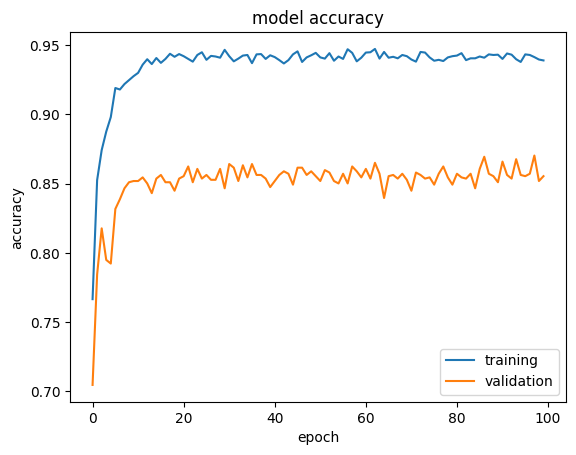

In [19]:
plot_accuracy(model2_history)

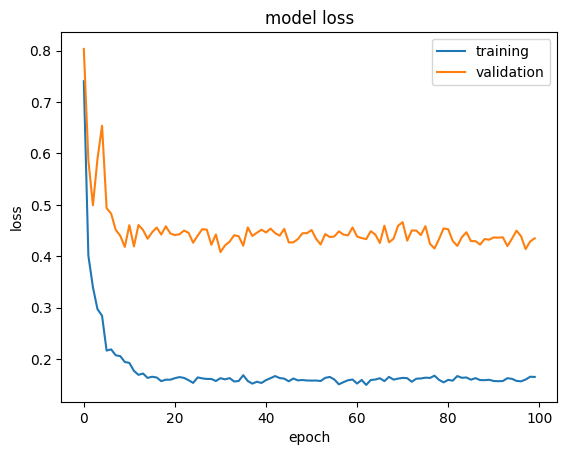

In [20]:
plot_loss(model2_history)

In [21]:
models2 = load_model('weight/vgg16_model.h5', compile=True)
pred = models2.predict(test_generator)
y_pred = np.argmax(pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=class_name))

              precision    recall  f1-score   support

      glioma       0.92      0.79      0.85       300
  meningioma       0.82      0.74      0.77       306
     notumor       0.94      0.97      0.95       405
   pituitary       0.82      0.99      0.90       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



PituitaryAdenoma.jpeg
Berdasarkan hasil prediksi, gambar dideteksi sebagai pituitary dengan nilai probabilitas 1.00 % .


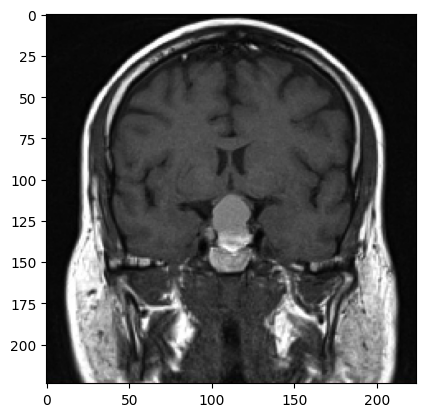

<Figure size 400x400 with 0 Axes>

In [25]:
predict_img('PituitaryAdenoma.jpeg', model=models2)